In [1]:
%matplotlib notebook 

import numpy
import scipy.optimize
import matplotlib.pyplot as plot

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [3]:
numpy.random.seed(1234)

In [4]:
# data set generation
n_dim = 2
n_mean = numpy.array([0., -1.])
n_cov = numpy.diag([0.2, .5])
p_mean = numpy.array([1., 1.])
p_cov = numpy.diag([.5, .3])

# generate postive examples
n_pos = 50
pos_y = numpy.ones(n_pos) 
pos_x = numpy.random.randn(n_pos, n_dim) * numpy.diag(p_cov)[None, :] + p_mean[None,:]
# generate negative examples
n_neg = 50
neg_y = numpy.zeros(n_neg)
neg_x = numpy.random.randn(n_neg, n_dim) * numpy.diag(n_cov)[None, :] + n_mean[None,:]
# combine them
y = numpy.concatenate([pos_y, neg_y])
x = numpy.concatenate([pos_x, neg_x], axis=0)
# shuffle them
si = numpy.random.permutation(n_pos + n_neg)
y = y[si]
x = x[si]

# grab training examples
n_tra = numpy.round(0.5 * (n_pos + n_neg)).astype(numpy.int)

y_tra = y[:n_tra]
x_tra = x[:n_tra]

y_tes = y[n_tra:]
x_tes = x[n_tra:]

In [5]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [6]:
def logreg(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return sigmoid(y)

In [7]:
def logreg_dist(y, x, w, avg=False):
    y_ = logreg(x, w)
    
    d = -(y * numpy.log(y_ + 1e-12) + (1. - y) * numpy.log(1-y_ + 1e-12))
    
    if not avg:
        return d
    return numpy.mean(d)

In [8]:
def logreg_rule(y, x, w):
    y_ = logreg(x, w)
    dw = numpy.zeros(w.shape)
    dw[:-1] = numpy.mean((y_tra - y_)[:, None] * x, axis=0)
    dw[-1] = numpy.mean(y_tra - y_)
    return dw

In [9]:
def _logreg_dist(w, x, y, avg=False):
    return logreg_dist(y, x, w, avg=avg), -logreg_rule(y, x, w)

In [10]:
w0 = numpy.random.randn(n_dim+1); w0[-1] = 0.
w = numpy.copy(w0)

res = scipy.optimize.minimize(_logreg_dist, w0, (x_tra, y_tra, False), method='L-BFGS-B', jac=True)

In [11]:
print res
w = res.x

      fun: array([  6.15441519e-08,   3.01674352e-10,   1.55181967e-09,
         9.61527063e-05,  -9.95203919e-13,   2.66095013e-09,
        -4.03899136e-13,   3.99878276e-09,   2.72462743e-04,
         3.85350066e-04,   7.48026086e-11,   3.66561115e-10,
        -2.79998247e-13,   4.08606482e-12,   2.46469511e-13,
         2.24221446e-07,   6.65503430e-10,   3.97234357e-10,
         1.06800124e-11,   3.86415344e-11,   1.98707717e-11,
         1.69951531e-09,   5.27246136e-10,   9.51237480e-08,
         9.09504546e-08,   3.33877370e-12,   3.48808047e-04,
         9.58510453e-09,   1.20943968e-06,   9.07735832e-08,
         1.99442685e-11,   1.39538492e-10,   1.94255868e-06,
         7.66004433e-08,   1.46078150e-10,   4.85653618e-08,
        -8.62643290e-13,   2.66991207e-10,   9.51274743e-08,
         8.80007178e-12,   4.36088943e-11,   4.10227408e-12,
         9.87796204e-08,  -9.73887637e-13,  -8.68416450e-13,
        -9.21041021e-13,   2.04752104e-10,   4.26265435e-09,
         5.60

In [12]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [13]:
def vis_hyperplane(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + w[-1])/w[1]
    intercept1 = -(w[0] * m1 + w[-1])/w[1]
    
    plt1, = plot.plot([m0, m1], [intercept0, intercept1], typ)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

<IPython.core.display.Javascript object>


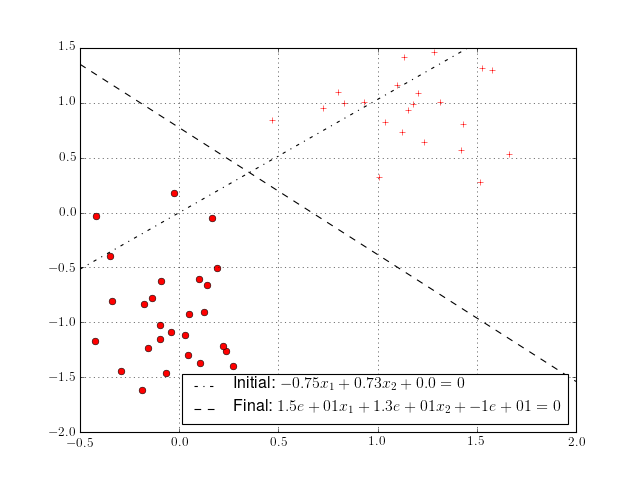

In [14]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
#vis_data(x_tes, y_tes, c='b')

plt0 = vis_hyperplane(w0, 'k-.')
plt1 = vis_hyperplane(w, 'k--')
plot.legend([plt0, plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)),
        'Final: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w))],
           loc='best')

plot.show()

In [15]:
tra_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tra, w)) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tes, w)) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.0, Test error rate 0.0
